## **ASSIGNMENT 2**

In [2]:
# data
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# models
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import tensorflow as tf
import numpy as np
import evaluate
from sklearn.metrics import f1_score, accuracy_score
from transformers import TrainingArguments
from transformers import Trainer
from torch.optim import SGD
from torch.optim import Adagrad


# others
import tqdm as notebook_tqdm
from pathlib import Path
import wget
import zipfile
import random
import torch.nn.functional as F
import os
import math

In [3]:
# Random seeds for robust estimation
random_seed1 = 101
random_seed2 = 102
random_seed3 = 103

# Check if CUDA (GPU support) is available
if torch.cuda.is_available(): # Print message if GPU is available
    print("CUDA is available. GPU will be used.")
else: # Print message if using CP
    print("You are using CPU")

CUDA is available. GPU will be used.


## **Task 1 - Corpus** 

In [4]:
def read_file(file_path):
    df = pd.read_csv(file_path, sep='\t', index_col='Argument ID')
    return df

# Function to merge level2 categories into more general level3 categories
def merge_annotations(data):
    level_3_categories = ['Openness to change', 'Self-enhancement', 'Coservation', 'Self-transcendence']
    for category in level_3_categories:
        level_2_columns = [col for col in data.columns if category.lower() in col.lower()]
        data[category] = data[level_2_columns].max(axis=1)
    data.drop(columns=level_2_columns, inplace=True)

def NaN_handler(df):
    df.fillna(inplace=True, value=0)
    
    for col in df.columns:
        if df[col].dtype == float:
            df[col] = df[col].astype('int64')
    
    return df

#### 1.1 Download data

In [5]:
url_argtrain = "https://zenodo.org/records/8248658/files/arguments-training.tsv?download=1"
url_argtest = "https://zenodo.org/records/8248658/files/arguments-test.tsv?download=1"
url_argval= "https://zenodo.org/records/8248658/files/arguments-validation.tsv?download=1"
url_labtrain = "https://zenodo.org/records/8248658/files/labels-training.tsv?download=1"
url_labtest = "https://zenodo.org/records/8248658/files/labels-test.tsv?download=1"
url_labval = "https://zenodo.org/records/8248658/files/labels-validation.tsv?download=1"


list_url = [url_argtrain,url_argtest,url_argval,url_labtrain,url_labtest,url_labval]
file_data_names = ['arguments-training.tsv','arguments-test.tsv','arguments-validation.tsv','labels-training.tsv','labels-test.tsv','labels-validation.tsv']

print(f"Current work directory: {Path.cwd()}\n")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

for data, file_name in zip(list_url, file_data_names):
    file_path = dataset_folder.joinpath(file_name)
    if not file_path.exists():
        print(f"Downloading {file_name} ...\n")
        wget.download(data, out=str(file_path))
    else: 
        print(f"Already downloaded {file_name} to {file_path}\n")
        

#visualize example
for file_name in file_data_names:
    file_path = dataset_folder.joinpath(file_name)
    if file_path.is_file():
        with file_path.open(mode='r', encoding='utf-8') as text_file:
            text = text_file.read()
            print(f"Content of {file_name}:\n{text}\n")
    else:
        print(f"Error in accessing {file_name}")

Current work directory: c:\Users\edoar\OneDrive\Desktop\Assignment2

Already downloaded arguments-training.tsv to c:\Users\edoar\OneDrive\Desktop\Assignment2\Datasets\arguments-training.tsv

Already downloaded arguments-test.tsv to c:\Users\edoar\OneDrive\Desktop\Assignment2\Datasets\arguments-test.tsv

Already downloaded arguments-validation.tsv to c:\Users\edoar\OneDrive\Desktop\Assignment2\Datasets\arguments-validation.tsv

Already downloaded labels-training.tsv to c:\Users\edoar\OneDrive\Desktop\Assignment2\Datasets\labels-training.tsv

Already downloaded labels-test.tsv to c:\Users\edoar\OneDrive\Desktop\Assignment2\Datasets\labels-test.tsv

Already downloaded labels-validation.tsv to c:\Users\edoar\OneDrive\Desktop\Assignment2\Datasets\labels-validation.tsv

Content of arguments-training.tsv:
Argument ID	Conclusion	Stance	Premise
A01002	We should ban human cloning	in favor of	we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans ru

In [6]:
path = os.getcwd()
print("Current Directory:", path)

train_arguments = read_file(path + '\\Datasets\\arguments-training.tsv')
val_arguments = read_file(path + '\\Datasets\\arguments-validation.tsv')
test_arguments = read_file(path + '\\Datasets\\arguments-test.tsv')

train_labels = read_file(path + '\\Datasets\\labels-training.tsv')
val_labels = read_file(path + '\\Datasets\\labels-validation.tsv')
test_labels = read_file(path + '\\Datasets\\labels-test.tsv')

# Merge the arguments and labels dataframes for training, validation, and test sets
train_df = pd.merge(train_arguments, train_labels, left_index=True, right_index=True)
val_df = pd.merge(val_arguments, val_labels, left_index=True, right_index=True)
test_df = pd.merge(test_arguments, test_labels, left_index=True, right_index=True)

# Merge level-2 annotations with level-3 categories for training, validation, and test sets
merge_annotations(train_df)
merge_annotations(val_df)
merge_annotations(test_df)

Current Directory: c:\Users\edoar\OneDrive\Desktop\Assignment2


In [7]:
train_df = NaN_handler(train_df)
val_df = NaN_handler(val_df)
test_df = NaN_handler(test_df)

#### 1.2 Dataframe structuring

In [8]:
# Macro categories
openness_to_change = ['Self-direction: thought','Self-direction: action', 'Stimulation']
self_enhancement = ['Achievement','Power: dominance', 'Power: resources']
conservation = ['Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules','Conformity: interpersonal']
self_transcendence = ['Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']

# Shared categories
hedonism = ['Hedonism']
face = ['Face']
humility = ['Humility']

def merge(df):
    conclusions = list(df['Conclusion'])
    stances = list(df['Stance'])
    premises = list(df['Premise'])
    zeros = [0] * len(df)

    new_df = pd.DataFrame({
        'Conclusion' : conclusions,
        'Stance' : stances,
        'Premise' : premises,
        'Openness to change' : zeros,
        'Self-enhancement' : zeros,
        'Conservation' : zeros,
        'Self-transcendence' : zeros
    }, index = df.index)

    # Populate the new dataframe based on the presence of subcategories
    for index, row in df.iterrows():
        if any(row[openness_to_change] == 1):
            new_df.at[index, 'Openness to change'] = 1
        if any(row[self_enhancement] == 1):
            new_df.at[index, 'Self-enhancement'] = 1
        if any(row[conservation] == 1):
            new_df.at[index, 'Conservation'] = 1
        if any(row[self_transcendence] == 1):
            new_df.at[index, 'Self-transcendence'] = 1
    
    # Handle shared categories and update the new dataframe
    for index, row in df.iterrows():
        if row['Hedonism'] == 1 and row['Face'] == 1:
            new_df.at[index, 'Self-enhancement'] = 1
        if row['Face'] == 1 and row['Humility'] == 1:
            new_df.at[index, 'Conservation'] = 1
                       
    return new_df

In [9]:
# Obtain the dataframes
train_df = merge(train_df)
val_df = merge(val_df)
test_df = merge(test_df)

# Check structure
train_df.head()

,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
Argument ID,,,,,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,1,0
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,1,0
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,1,1,0
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,1,1
A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,1,1


#### 1.3 Visulization of the data

In [10]:
categories = list(train_df.columns)

categories = categories[3:7]
print(f"The considered categories are: {categories}")

The considered categories are: ['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']


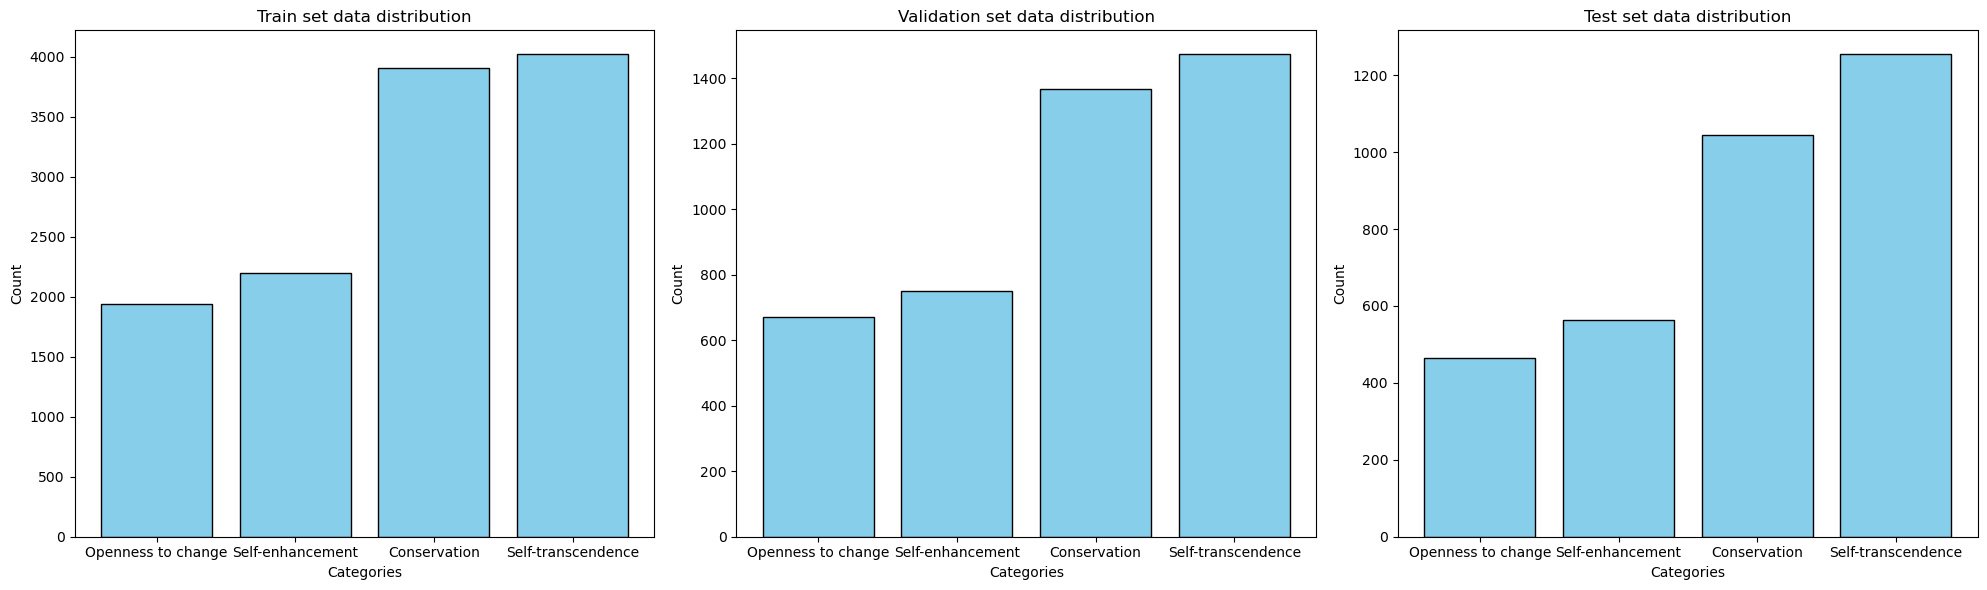

In [11]:
# Visualize the distribution in the classes in the considered categories for each dataset (Train, Validation, Test)
dfs = [train_df, val_df, test_df]

names = ['Train', 'Validation', 'Test']
fig, axes = plt.subplots(1, 3, figsize=(20, 6))


for i, df in enumerate(dfs):

    counts = df[categories].sum()
    positions = range(len(counts)) 

    axes[i].bar(positions, counts, color='skyblue', edgecolor='black')

    axes[i].set_title(f'{names[i]} set data distribution')
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel('Count')
    axes[i].set_xticks(positions)
    axes[i].set_xticklabels(counts.index)

plt.tight_layout()
plt.show()

In [12]:
def length_plot(df, threshold, name):
    '''
    Compute the length of sentences in the 'Conclusion' and 'Premise' columns and plot the result, also it displays the 
    length value below which the %treshold% quantity of data is found.
    '''
    df['ConclusionSentences'] = df['Conclusion'].apply(lambda x: len(x.split()))
    df['PremiseSentences'] = df['Premise'].apply(lambda x: len(x.split()))

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i, column_name in enumerate(['ConclusionSentences', 'PremiseSentences']):
     
        sns.boxplot(data=df[[column_name]], ax=axes[i])
        axes[i].axhline(y=threshold[i], color='red', linestyle='--', label=f'{column_name} - Threshold')  
        axes[i].set_title(f'{column_name} length for {name} set')
        axes[i].set_xlabel('Sentence Type')
        axes[i].set_ylabel('Length')
        axes[i].legend()

        below_threshold_percentage = (df[column_name] < threshold[i]).mean() * 100
        axes[i].text(0.5, -0.2, f'Below {threshold[i]} threshold: {below_threshold_percentage:.2f}%', transform=axes[i].transAxes, ha='center')

    plt.tight_layout()
    plt.show()


def truncate_column_after_words(df, text_column, max_words):
    '''
    The length of premise is usually higher than conclusion, in order to avoid too much loss information in the CP and CPS models
    we considered the following solution: we found which length was higher than the 90% of the data in Premise column and
    truncate teh column after that many word. In this way we can be sure that in 90% of teh cases both premise and conclusion are considered.
    '''

    def truncate_text(text, max_words):
        words = text.split()
        truncated_text = ' '.join(words[:max_words])
        return truncated_text

    # Truncate the specified column after a certain number of words
    df[text_column] = df[text_column].apply(lambda x: truncate_text(x, max_words))

    return df

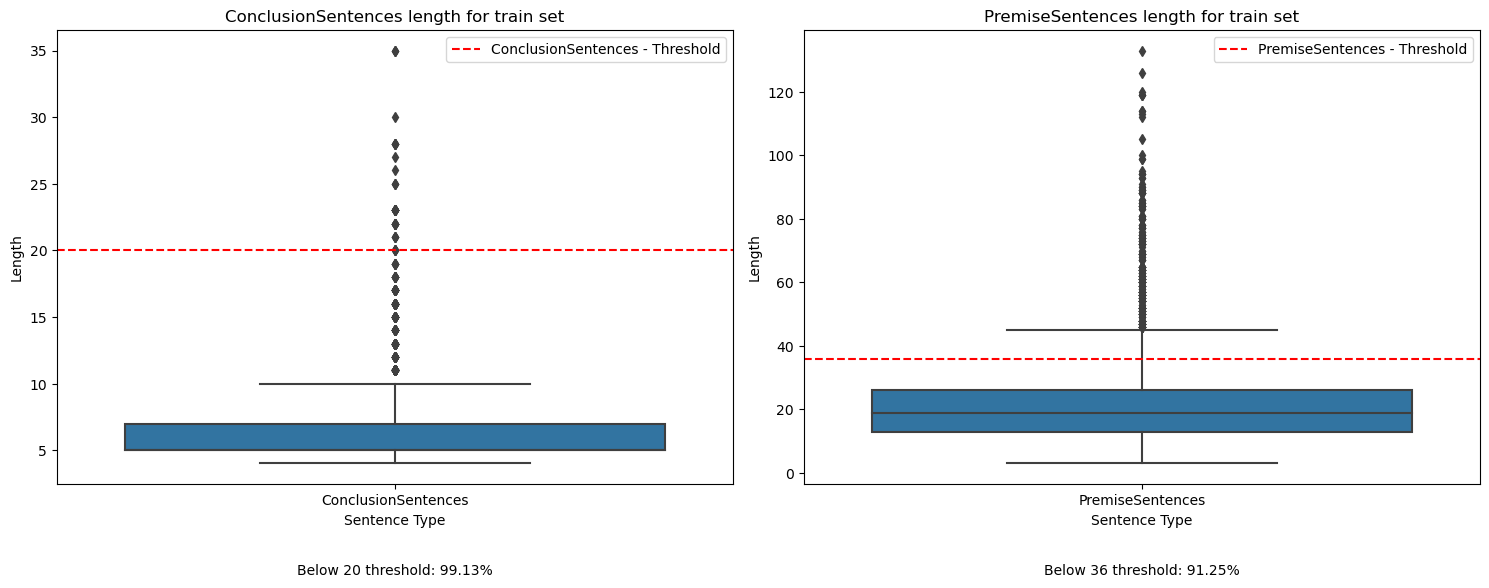

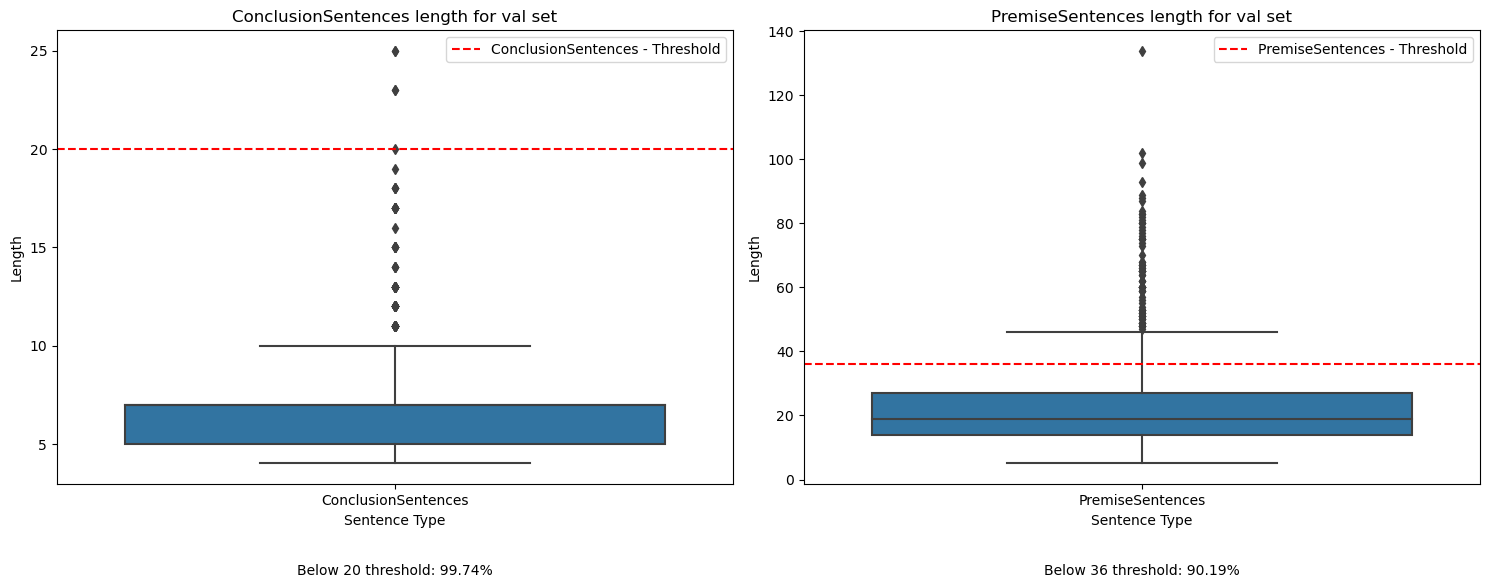

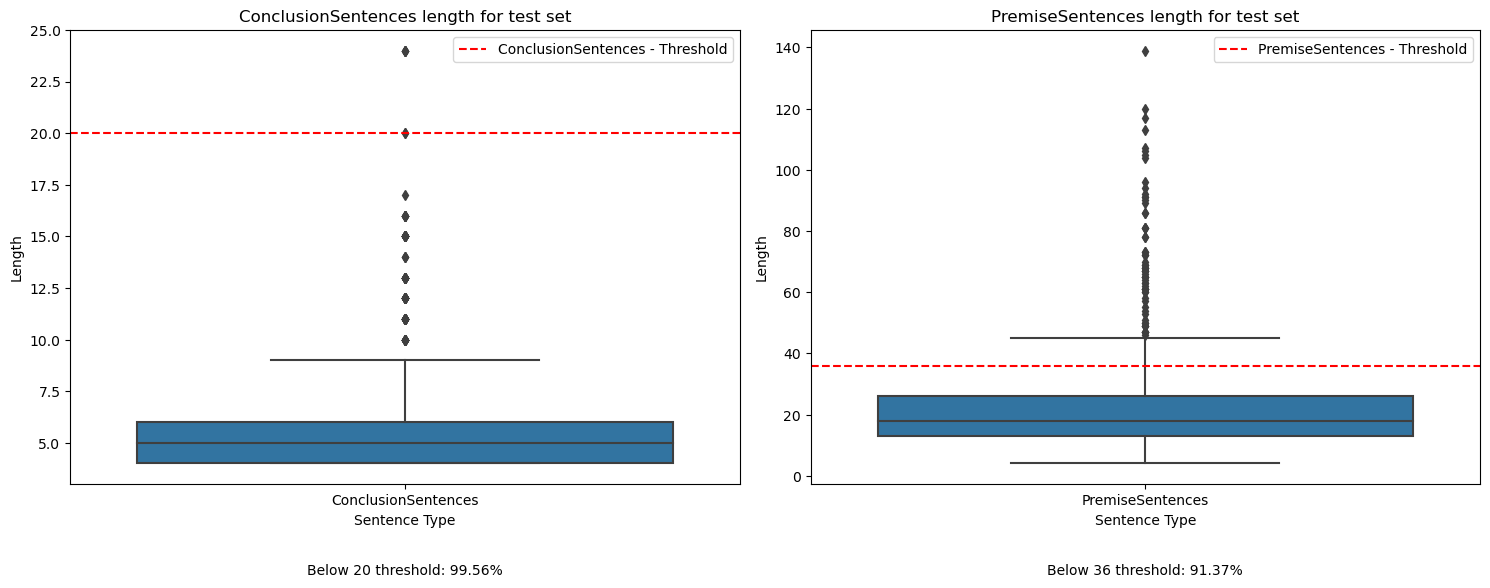

In [13]:
length_plot(train_df, threshold=[20, 36], name='train')
length_plot(val_df, threshold=[20, 36], name='val')
length_plot(test_df, threshold=[20, 36], name='test')

We choose as **max_sequence_length** for C and CP (conclusion + premise) respectively **20** and **36** because a good amount of data is below that length. So, without impacting too much the training process, we can speed up computations, reducing the need of longer padding.

In [14]:
max_words_to_keep = 36

# Truncate premise
train_df = truncate_column_after_words(train_df, 'Premise', max_words_to_keep)
val_df = truncate_column_after_words(val_df, 'Premise', max_words_to_keep)
test_df = truncate_column_after_words(test_df, 'Premise', max_words_to_keep)

In [15]:
max_sequence_length_C = 20 # 99% of conclusion sentences have length less than 20
max_sequence_length_CP = 56 # 90% pf premise sentences have length less than 36. The total will be 36+20

model_card = 'bert-base-uncased'

#### 1.4 Tokenization

In [16]:
def tokenization(model_card, train, val, test, max_sequence_length_C, max_sequence_lenth_CP):

    tokenizer = AutoTokenizer.from_pretrained(model_card)

    # Tokenize Conclusion
    inputC_train = tokenizer(list(train['Conclusion']), padding=True, truncation=True, return_tensors='pt', max_length=max_sequence_length_C)
    inputC_val = tokenizer(list(val['Conclusion']), padding=True, truncation=True, return_tensors='pt', max_length=max_sequence_length_C)
    inputC_test = tokenizer(list(test['Conclusion']), padding=True, truncation=True, return_tensors='pt', max_length=max_sequence_length_C)
    
    #Tokenize Conclusion and premise
    inputCP_train = tokenizer(list(train['Combined_Text']), padding=True, truncation=True, return_tensors='pt', max_length=max_sequence_lenth_CP)
    inputCP_val = tokenizer(list(val['Combined_Text']), padding=True, truncation=True, return_tensors='pt', max_length=max_sequence_lenth_CP)
    inputCP_test = tokenizer(list(test['Combined_Text']), padding=True, truncation=True, return_tensors='pt', max_length=max_sequence_lenth_CP)

    return inputC_train, inputC_val, inputC_test, inputCP_train, inputCP_val, inputCP_test

In [17]:
# Concatenate Conclusion and Premise columns and convert to strings
train_df['Combined_Text'] = train_df['Premise'].astype(str) + ' ' + train_df['Conclusion'].astype(str)
val_df['Combined_Text'] = val_df['Premise'].astype(str) + ' ' + val_df['Conclusion'].astype(str)
test_df['Combined_Text'] = test_df['Premise'].astype(str) + ' ' + test_df['Conclusion'].astype(str)

inputC_train, inputC_val, inputC_test, inputCP_train, inputCP_val, inputCP_test = tokenization(model_card, train_df, val_df, test_df, max_sequence_length_C, max_sequence_length_CP)

In [18]:
# Also we encode the stance column
label_encoderTrain = LabelEncoder()
label_encoderVal = LabelEncoder()
label_encoderTest= LabelEncoder()

print(f"Before encoding we have this kind of stance values: {train_df['Stance'][2]}, {val_df['Stance'][1]}, {test_df['Stance'][0]}")

train_df['Stance'] = label_encoderTrain.fit_transform(train_df['Stance']) 
val_df['Stance'] = label_encoderVal.fit_transform(val_df['Stance']) 
test_df['Stance'] = label_encoderTest.fit_transform(test_df['Stance']) 

print(f"After encoding we have this kind of stance values: {train_df['Stance'][2]}, {val_df['Stance'][1]}, {test_df['Stance'][0]}")

Before encoding we have this kind of stance values: against, in favor of, against
After encoding we have this kind of stance values: 0, 1, 0


## **TASK 2 - Model Definition**

#### 2.1 Define the baselines and the linear classifier

In [19]:
# Define baseline 1: Random uniform classifier
def random_uniform_classifier(df, random_seed):
    np.random.seed(random_seed)
    predictions = pd.DataFrame(index=df.index, columns=categories)
    for category in categories:
        predictions[category] = np.random.randint(2, size=len(df))
    return predictions

# Define baseline 2: Majority classifier  
def majority_classifier(df, random_seed):
    predictions = pd.DataFrame(index=df.index, columns=categories)
    for category in categories:
        majority_label = df[category].mode().iloc[0]
        predictions[category] = majority_label
    return predictions

# Define the linear classifier
class BinaryLinearClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryLinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, 2)  

    def forward(self, embeddings):

        # Flatten the embeddings (assuming the second dimension is the sequence length)
        flattened_embeddings = embeddings.view(embeddings.size(0), -1)
        linear_output = self.linear(flattened_embeddings)
        output_probs = F.sigmoid(linear_output)

        return output_probs

    def predict(self, embeddings, threshold=0.5):
        
        output_probs = self.forward(embeddings)
        binary_predictions = (output_probs[:, 1] > threshold).float()

        return binary_predictions

In [20]:
# Define the embedder
def Bert_Embedder(random_seed, model_card):

    # Set random seeds for reproducibility
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    model = AutoModelForSequenceClassification.from_pretrained(model_card, output_hidden_states = True)

    return model

#### 2.2 Models creation

In [21]:
#Bert_Models
modelC1 = Bert_Embedder(random_seed1, model_card)
modelC2 = Bert_Embedder(random_seed2, model_card)
modelC3 = Bert_Embedder(random_seed3, model_card)

modelCP1 = Bert_Embedder(random_seed1, model_card)
modelCP2 = Bert_Embedder(random_seed2, model_card)
modelCP3 = Bert_Embedder(random_seed3, model_card)

modelCPS1 = Bert_Embedder(random_seed1, model_card)
modelCPS2 = Bert_Embedder(random_seed2, model_card)
modelCPS3 = Bert_Embedder(random_seed3, model_card)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

## **TASK 3 - Metrics**

In [22]:
# Functions to compute the per-category and macro f1 score
def binary_f1_score(predictions, labels):

    true_positives = torch.sum(predictions * labels)
    false_positives = torch.sum(predictions * (1 - labels))
    false_negatives = torch.sum((1 - predictions) * labels)

    precision = true_positives / (true_positives + false_positives + 1e-10)
    recall = true_positives / (true_positives + false_negatives + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    return f1.item()

def average_binary_f1_score(all_predictions, all_labels):

    per_category_f1_scores = [binary_f1_score(predictions, labels) for predictions, labels in zip(all_predictions, all_labels)]
    average_f1_score = sum(per_category_f1_scores) / len(per_category_f1_scores)

    return average_f1_score

def baseline_predictions(baseline, df):
    predictions = baseline(df, random_seed1)
    return predictions

# Computes F1 scores for each category based on baseline predictions
def f1_score_baseline(df, predictions):
    acc = []
    f1s = []
    for category in categories:
        accumulator = []
        tp = sum((df[category] ==  1) & (predictions[category] == 1))
        accumulator.append(tp)
        fp = sum((df[category] == 0) & (predictions[category] == 1))
        accumulator.append(fp)
        fn = sum((df[category] == 1) & (predictions[category] == 0))
        accumulator.append(fn)
        acc.append(accumulator)
    for i in acc:
        precision = i[0] / (i[0] + i[1]) if (i[0] + i[1]) > 0 else 0
        recall = i[0] / (i[0] + i[2]) if (i[0] + i[2]) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        f1s.append(f1)
    
    return f1s

def macro_f1_score(f1_scores):
    
    # Computes the macro F1 score given a list of F1 scores for each category
    macro = sum(f1_scores) / len(f1_scores)
    return macro

## **TASK 4 - Training and Evaluation**

#### 4.1 Functions

In [23]:
def labels_compute(df):
    '''
    This function create a list of labels where each element refers to a particular category
    '''
    labels = np.array(df[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']])
    labels = torch.tensor(labels, dtype=torch.float32) 

    labels_Opennes = labels[:,0] 
    labels_enhance = labels[:,1] 
    labels_Conserv = labels[:,2] 
    labels_Transce = labels[:,3] 

    labels_list = [labels_Opennes, labels_enhance, labels_Conserv, labels_Transce]

    return labels_list

def embeddings(BertModel, input_data):
    with torch.no_grad():
        outputs = BertModel(**input_data)
        hidden_states = outputs.hidden_states 
        embeddings = hidden_states[-1] 
    
    print(f"The embedding size of the model is : {embeddings.size()}")
    return embeddings

In [24]:
def label_tensor(df, mode):

    '''
    This function concatenate the values of Stance in numeric format to the embeddings for CP models. In this
    way we obtain the embeddings for CPS models.
    '''
    one = np.ones([1, 768], dtype=float)
    stance = 0

    if mode == 'train':
        stance = np.zeros([5393, 1, 768], dtype=float)
    if mode == 'val':
        stance = np.zeros([1896, 1, 768], dtype=float)
    if mode == 'test':
        stance = np.zeros([1576, 1, 768], dtype=float)

    idx = df['Stance'] == 1
    stance[idx] = one

    # Check for errors
    for i in range(len(df)):
        if stance[i].sum()!=0 and idx[i]==False:
            print('Error')
        if stance[i].sum()==0 and idx[i]==True:
            print('Error')

    return torch.from_numpy(stance).to(torch.float32)

Train binary classifiers for each category (Openness to change, Self-enhancement, Conservation, Self-transcendence).

In [25]:
def train_binary_classifier(embeddings, labels_list, num_epochs, input_size, learning_rate, name):

    names = {1:"Opennes_to_change", 2:"Self_enhancement", 3:"Conservation",4:"Self_Transcendence"}

    binary_classifier_opennes = BinaryLinearClassifier(input_size)
    binary_classifier_enhance = BinaryLinearClassifier(input_size)
    binary_classifier_conserv = BinaryLinearClassifier(input_size)
    binary_classifier_transce = BinaryLinearClassifier(input_size)

    list_clf = [binary_classifier_opennes, binary_classifier_enhance, binary_classifier_conserv, binary_classifier_transce]
    list_clf_output = []

    for i in range(len(list_clf)):
        classifier = list_clf[i]
        labels = labels_list[i]

        optimizer = SGD(classifier.parameters(), lr=learning_rate)
        criterion =  torch.nn.BCELoss()
        epoch_losses = []

        for epoch in range(num_epochs):
        
            predictions = classifier(embeddings)
            loss = criterion(predictions[:, 1], labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        list_clf_output.append(classifier)

        # Plot loss history
        plt.title(f'Model {name} Loss history ')
        plt.plot(range(1, num_epochs+1), epoch_losses, label=f'{names[i + 1]} Loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return list_clf_output

#### 4.2 Embeddings

##### 4.2.1 Train set embeddings

In [26]:
#BertC
embeddingsC1_train = embeddings(modelC1, inputC_train)
embeddingsC2_train = embeddings(modelC2, inputC_train)
embeddingsC3_train = embeddings(modelC3, inputC_train)

#BertCP
embeddingsCP1_train = embeddings(modelCP1, inputCP_train)
embeddingsCP2_train = embeddings(modelCP2, inputCP_train)
embeddingsCP3_train = embeddings(modelCP3, inputCP_train)

#BertCPS
Stance = label_tensor(train_df, mode='train')

embeddingsCPS1_train = torch.cat([embeddingsCP1_train, Stance], dim=1)
embeddingsCPS2_train = torch.cat([embeddingsCP2_train, Stance], dim=1)
embeddingsCPS3_train = torch.cat([embeddingsCP3_train, Stance], dim=1)

print(f"The embedding size of the CPS model is {embeddingsCPS1_train.size()}")
print(f"The embedding size of the CPS model is {embeddingsCPS2_train.size()}")
print(f"The embedding size of the CPS model is {embeddingsCPS3_train.size()}")

The embedding size of the model is : torch.Size([5393, 5, 768])
The embedding size of the model is : torch.Size([5393, 5, 768])
The embedding size of the model is : torch.Size([5393, 5, 768])
The embedding size of the model is : torch.Size([5393, 10, 768])
The embedding size of the model is : torch.Size([5393, 10, 768])
The embedding size of the model is : torch.Size([5393, 10, 768])
The embedding size of the CPS model is torch.Size([5393, 11, 768])
The embedding size of the CPS model is torch.Size([5393, 11, 768])
The embedding size of the CPS model is torch.Size([5393, 11, 768])


##### 4.2.2 Val set embeddings

In [27]:
#BertC
embeddingsC1_val = embeddings(modelC1, inputC_val)
embeddingsC2_val = embeddings(modelC2, inputC_val)
embeddingsC3_val= embeddings(modelC3, inputC_val)

#BertCP
embeddingsCP1_val = embeddings(modelCP1, inputCP_val)
embeddingsCP2_val = embeddings(modelCP2, inputCP_val)
embeddingsCP3_val = embeddings(modelCP3, inputCP_val)

#BertCPS
Stance = label_tensor(val_df, mode='val')

embeddingsCPS1_val = torch.cat([embeddingsCP1_val, Stance], dim=1)
embeddingsCPS2_val = torch.cat([embeddingsCP2_val, Stance], dim=1)
embeddingsCPS3_val = torch.cat([embeddingsCP3_val, Stance], dim=1)

print(f"The embedding size of the model is {embeddingsCPS1_val.size()}")
print(f"The embedding size of the model is {embeddingsCPS2_val.size()}")
print(f"The embedding size of the model is {embeddingsCPS3_val.size()}")

The embedding size of the model is : torch.Size([1896, 5, 768])
The embedding size of the model is : torch.Size([1896, 5, 768])
The embedding size of the model is : torch.Size([1896, 5, 768])
The embedding size of the model is : torch.Size([1896, 10, 768])
The embedding size of the model is : torch.Size([1896, 10, 768])
The embedding size of the model is : torch.Size([1896, 10, 768])
The embedding size of the model is torch.Size([1896, 11, 768])
The embedding size of the model is torch.Size([1896, 11, 768])
The embedding size of the model is torch.Size([1896, 11, 768])


##### 4.2.3 Test set embeddings

In [28]:
#BertC
embeddingsC1_test = embeddings(modelC1, inputC_test)
embeddingsC2_test = embeddings(modelC2, inputC_test)
embeddingsC3_test = embeddings(modelC3, inputC_test)

#BertCP
embeddingsCP1_test = embeddings(modelCP1, inputCP_test)
embeddingsCP2_test = embeddings(modelCP2, inputCP_test)
embeddingsCP3_test = embeddings(modelCP3, inputCP_test)

#BertCPS
Stance = label_tensor(test_df, mode='test')

embeddingsCPS1_test = torch.cat([embeddingsCP1_test, Stance], dim=1)
embeddingsCPS2_test = torch.cat([embeddingsCP2_test, Stance], dim=1)
embeddingsCPS3_test = torch.cat([embeddingsCP3_test, Stance], dim=1)

print(f"The embedding size of the model is {embeddingsCPS1_test.size()}")
print(f"The embedding size of the model is {embeddingsCPS2_test.size()}")
print(f"The embedding size of the model is {embeddingsCPS3_test.size()}")

The embedding size of the model is : torch.Size([1576, 5, 768])
The embedding size of the model is : torch.Size([1576, 5, 768])
The embedding size of the model is : torch.Size([1576, 5, 768])
The embedding size of the model is : torch.Size([1576, 10, 768])
The embedding size of the model is : torch.Size([1576, 10, 768])
The embedding size of the model is : torch.Size([1576, 10, 768])
The embedding size of the model is torch.Size([1576, 11, 768])
The embedding size of the model is torch.Size([1576, 11, 768])
The embedding size of the model is torch.Size([1576, 11, 768])


#### 4.3 Labels

In [29]:
labels_train = labels_compute(train_df)
val_labels = labels_compute(val_df)
test_labels = labels_compute(test_df)

#### 4.4 Training

In [32]:
# Hyperparameters for training
num_epochs = 200
last_hidden_layer_units = 768
learning_rate = 0.003 

embedding_dimension_C = embeddingsC1_train.size(1)
embedding_dimension_CP = embeddingsCP1_train.size(1)
embedding_dimension_CPS = embeddingsCPS1_train.size(1)

input_size_C = embedding_dimension_C*last_hidden_layer_units
input_size_CP = embedding_dimension_CP*last_hidden_layer_units
input_size_CPS = embedding_dimension_CPS*last_hidden_layer_units

print('**** PARAMETERS ****')
print('Input size C:', input_size_C)
print('Input size CP:', input_size_CP)
print('Input size CPS:', input_size_CPS)

print('\nDimension of C embedding:', embedding_dimension_C)
print('Dimension of CP embedding:', embedding_dimension_CP)
print('Dimension of CPS embedding', embedding_dimension_CPS)

print('\nNumber of epochs:', num_epochs)
print('Units of the last hidden layer:', last_hidden_layer_units)
print('Learning rate: ', learning_rate)

**** PARAMETERS ****
Input size C: 3840
Input size CP: 7680
Input size CPS: 8448

Dimension of C embedding: 5
Dimension of CP embedding: 10
Dimension of CPS embedding 11

Number of epochs: 100
Units of the last hidden layer: 768
Learning rate:  0.003


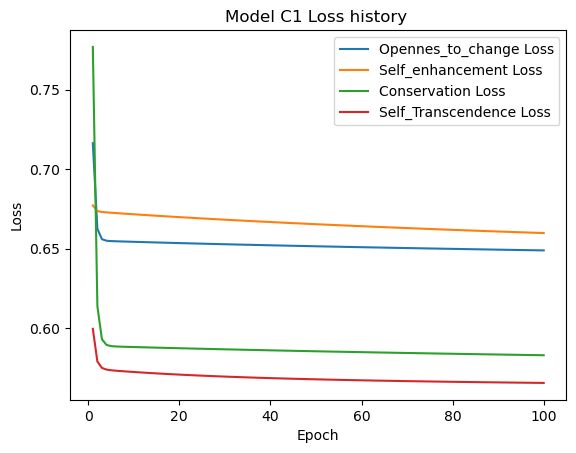

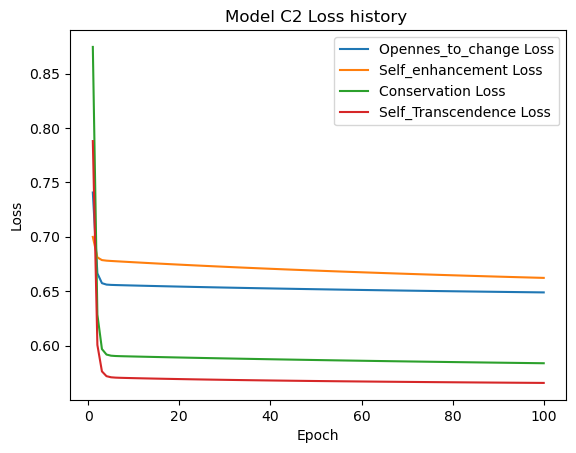

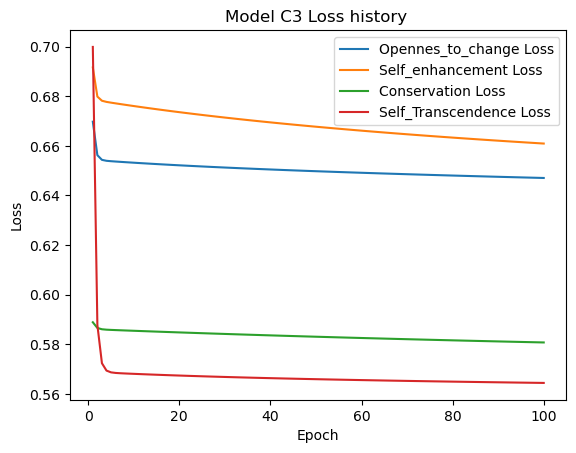

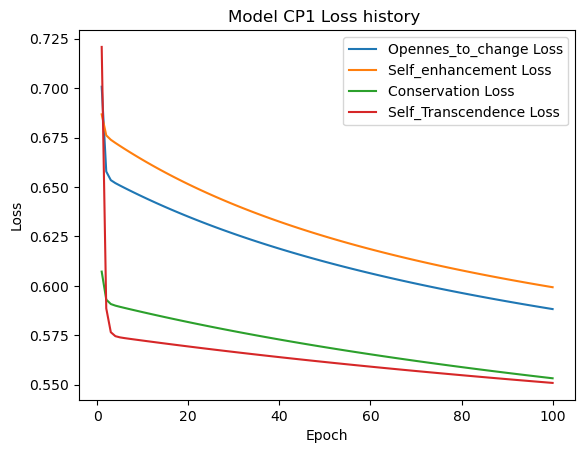

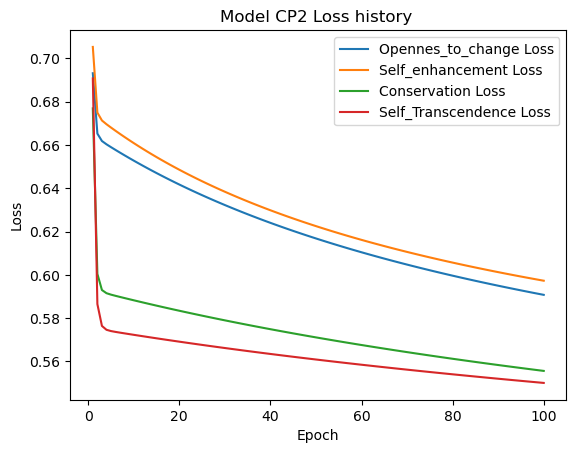

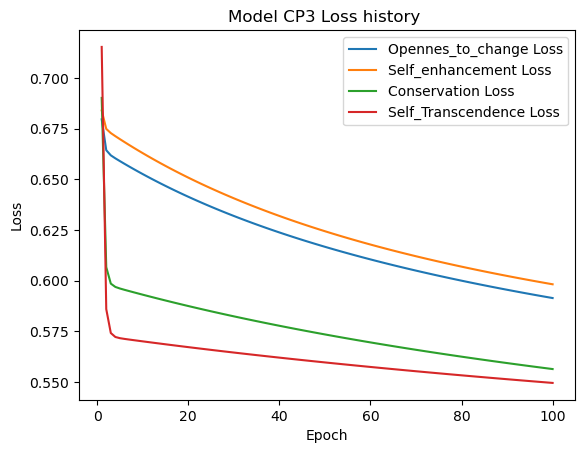

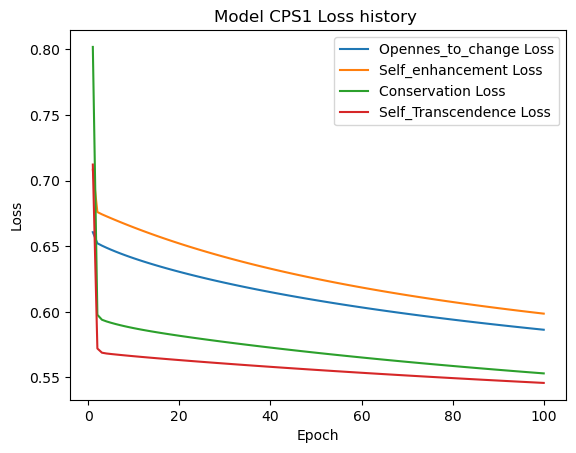

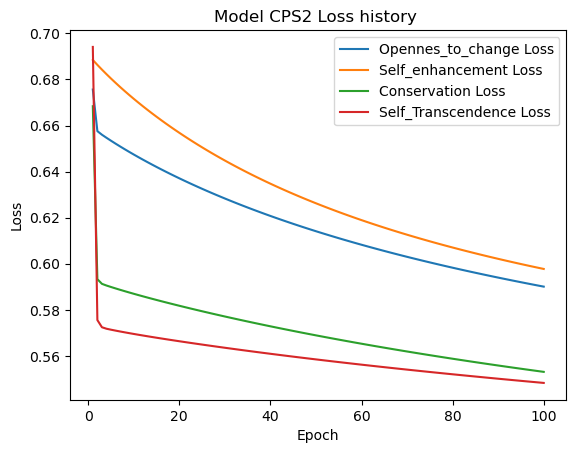

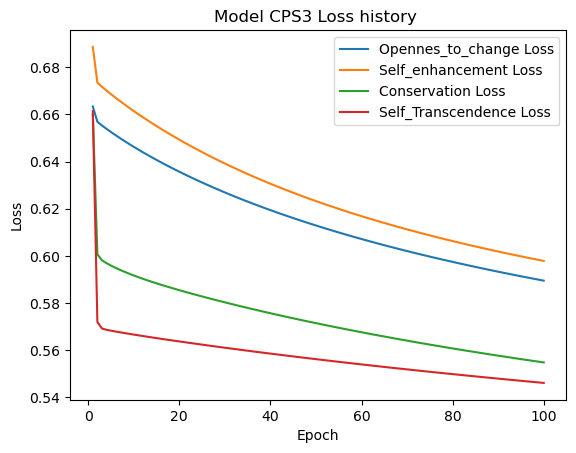

In [33]:
#clf BertC
clf_bert_C1_list = train_binary_classifier(embeddingsC1_train, labels_train, num_epochs, input_size_C, learning_rate, name = 'C1')
clf_bert_C2_list = train_binary_classifier(embeddingsC2_train, labels_train, num_epochs, input_size_C, learning_rate, name = 'C2')
clf_bert_C3_list = train_binary_classifier(embeddingsC3_train, labels_train, num_epochs, input_size_C, learning_rate, name = 'C3')

#clf BertCP
clf_bert_CP1_list = train_binary_classifier(embeddingsCP1_train, labels_train, num_epochs, input_size_CP, learning_rate, name = 'CP1')
clf_bert_CP2_list = train_binary_classifier(embeddingsCP2_train, labels_train, num_epochs, input_size_CP, learning_rate, name = 'CP2')
clf_bert_CP3_list = train_binary_classifier(embeddingsCP3_train, labels_train, num_epochs, input_size_CP, learning_rate, name = 'CP3')

#clf BertCPS
clf_bert_CPS1_list = train_binary_classifier(embeddingsCPS1_train, labels_train, num_epochs, input_size_CPS, learning_rate, name = 'CPS1')
clf_bert_CPS2_list = train_binary_classifier(embeddingsCPS2_train, labels_train, num_epochs, input_size_CPS, learning_rate, name = 'CPS2')
clf_bert_CPS3_list = train_binary_classifier(embeddingsCPS3_train, labels_train, num_epochs, input_size_CPS, learning_rate, name = 'CPS3')

#### 4.5 Evaluation

In [34]:
# Print the F1 score for each category and the macro F1 score
def f1_print(f1_single_radn, f1_avg_radn):

    names = {1:"Opennes_to_change", 2:"Self_enhancement", 3:"Conservation",4:"Self_Transcendence"}

    for i in range(len(f1_single_radn)):
        print(f"F1 score for {names[i+1]}: {f1_single_radn[i]:.3f}")
    print(f"\nMacro F1 score: {f1_avg_radn:.3f}")

# Evaluate the binary classifiers and prints the F1 scores
def evaluate_classifier(trained_clf, embeddings, labels_list, name):
    
    avgf1_score = 0
    catf1_score = [0, 0, 0, 0]

    flattened_embeddings = embeddings.view(embeddings.size(0), -1)

    for i in range(len(trained_clf)):

        classifier = trained_clf[i]
        labels = labels_list[i]
        catf1_score[i] = binary_f1_score(classifier.predict(flattened_embeddings), labels)
   
    avgf1_score = (sum(catf1_score)/len(catf1_score)) 
    print(f"\n--------------------------------------------------------\n{name} CLASSIFIERS: \n")
    f1_print(catf1_score, avgf1_score)
    return catf1_score, avgf1_score

# Identify and print the best seed for a given model based on average F1 scores
def get_best(model, name):
    averages = {key: sum(values) / len(values) for key, values in model.items()}
    best_key = max(averages, key=averages.get)
    best_list = model[best_key]
    print(f'The best seed for {name} is: {best_key}')
    return best_list

Evaluation of BERT models

In [35]:
#BertC
bert_c_results1, macro_bertC_1 = evaluate_classifier(clf_bert_C1_list, embeddingsC1_val, val_labels, name="C1")
bert_c_results2, macro_bertC_2 = evaluate_classifier(clf_bert_C2_list, embeddingsC2_val, val_labels, name="C2")
bert_c_results3, macro_bertC_3 = evaluate_classifier(clf_bert_C3_list, embeddingsC3_val, val_labels, name="C3")

#BertCP
bert_cp_results1, macro_bertCP_1 = evaluate_classifier(clf_bert_CP1_list, embeddingsCP1_val, val_labels, name="CP1")
bert_cp_results2, macro_bertCP_2 = evaluate_classifier(clf_bert_CP2_list, embeddingsCP2_val, val_labels, name="CP2")
bert_cp_results3, macro_bertCP_3 = evaluate_classifier(clf_bert_CP3_list, embeddingsCP3_val, val_labels, name="CP3")

#BertCPS
bert_cps_results1, macro_bertCPS_1 = evaluate_classifier(clf_bert_CPS1_list, embeddingsCPS1_val, val_labels, name="CPS1")
bert_cps_results2, macro_bertCPS_2 = evaluate_classifier(clf_bert_CPS2_list, embeddingsCPS2_val, val_labels, name="CPS2")
bert_cps_results3, macro_bertCPS_3 = evaluate_classifier(clf_bert_CPS3_list, embeddingsCPS3_val, val_labels, name="CPS3")


--------------------------------------------------------
C1 CLASSIFIERS: 

F1 score for Opennes_to_change: 0.000
F1 score for Self_enhancement: 0.301
F1 score for Conservation: 0.838
F1 score for Self_Transcendence: 0.874

Macro F1 score: 0.503

--------------------------------------------------------
C2 CLASSIFIERS: 

F1 score for Opennes_to_change: 0.000
F1 score for Self_enhancement: 0.117
F1 score for Conservation: 0.838
F1 score for Self_Transcendence: 0.874

Macro F1 score: 0.457

--------------------------------------------------------
C3 CLASSIFIERS: 

F1 score for Opennes_to_change: 0.000
F1 score for Self_enhancement: 0.333
F1 score for Conservation: 0.838
F1 score for Self_Transcendence: 0.874

Macro F1 score: 0.511

--------------------------------------------------------
CP1 CLASSIFIERS: 

F1 score for Opennes_to_change: 0.169
F1 score for Self_enhancement: 0.430
F1 score for Conservation: 0.838
F1 score for Self_Transcendence: 0.874

Macro F1 score: 0.578

--------------

In [36]:
# We will analyse the performances of the models considering only the best seed for each of them
bertC_macro = {'Seed1' : bert_c_results1, 
              'Seed2' : bert_c_results2, 
              'Seed3' : bert_c_results3
}

bertCP_macro = {'Seed1' : bert_cp_results1, 
               'Seed2' : bert_cp_results2, 
               'Seed3' : bert_cp_results3
}

bertCPS_macro = {'Seed1' : bert_cps_results1, 
               'Seed2' : bert_cps_results2, 
               'Seed3' : bert_cps_results3
}

best_bertC = get_best(bertC_macro, 'Bert C model')
best_bertCP = get_best(bertCP_macro, 'Bert CP model')
best_bertCPS = get_best(bertCPS_macro, 'Bert CPS model')

The best seed for Bert C model is: Seed3
The best seed for Bert CP model is: Seed3
The best seed for Bert CPS model is: Seed1


Best model evaluation based on average performance

In [40]:
def average_score(score_list):
    count = 0
    for score in score_list:
        count += score
    return count/3

def standard_deviation(score_list):
    mean = sum(score_list) / len(score_list)
    squared_diff = [(score - mean) ** 2 for score in score_list]
    variance = sum(squared_diff) / len(score_list)
    std_dev = math.sqrt(variance)

    return std_dev

ModelC_scores = [macro_bertC_1, macro_bertC_2, macro_bertC_3]
ModelCP_scores = [macro_bertCP_1, macro_bertCP_2, macro_bertCP_3]
ModelCPS_scores = [macro_bertCPS_1, macro_bertCPS_2, macro_bertCPS_3]

# Calculate average scores and standard deviation
average_score_modelC = average_score(ModelC_scores)
average_score_modelCP = average_score(ModelCP_scores)
average_score_modelCPS = average_score(ModelCPS_scores)
std_dev_modelC = standard_deviation(ModelC_scores)
std_dev_modelCP = standard_deviation(ModelCP_scores)
std_dev_modelCPS = standard_deviation(ModelCPS_scores)

print('Average score of modelC: ', round(average_score_modelC, 3))
print('Average score of modelCP: ', round(average_score_modelCP, 3))
print('Average score of modelCPS: ', round(average_score_modelCPS, 3))
print('\n\nStandard Deviation of modelC: ', round(std_dev_modelC, 3))
print('Standard Deviation of modelCP: ', round(std_dev_modelCP, 3))
print('Standard Deviation of modelCPS: ', round(std_dev_modelCPS, 3))
print()
print("The best model is CPS")

Average score of modelC:  0.49
Average score of modelCP:  0.588
Average score of modelCPS:  0.599


Standard Deviation of modelC:  0.024
Standard Deviation of modelCP:  0.008
Standard Deviation of modelCPS:  0.003
The best model is CPS


## **TASK 5 - Error Analysis**

#### 5.1 Compare classification performance of BERT-based models with respect to baselines

In [ ]:
# Per-category and macro f1_score random uniform classifier
random_predictions = baseline_predictions(random_uniform_classifier, val_df)
random_f1s = f1_score_baseline(val_df, random_predictions)
random_macro = macro_f1_score(random_f1s)

print('RANDOM UNIFORM CLASSIFIER:')
for i in range(len(random_f1s)):
    print(f'F1 score for {categories[i]}: {round(random_f1s[i], 3)}')
print(f'\nMacro F1 score: {round(random_macro, 3)}')


# Per-category and macro f1_score majority classifier
majority_predictions = baseline_predictions(majority_classifier, val_df)
majority_f1s = f1_score_baseline(val_df, majority_predictions)
majority_macro = macro_f1_score(majority_f1s)

print('\n\nMAJORITY CLASSIFIER:')
for i in range(len(majority_f1s)):
    print(f'F1 score for {categories[i]}: {round(majority_f1s[i], 3)}')
print(f'\nMacro F1 score: {round(majority_macro, 3)}')

RANDOM UNIFORM CLASSIFIER:
F1 score for Openness to change: 0.413
F1 score for Self-enhancement: 0.449
F1 score for Conservation: 0.592
F1 score for Self-transcendence: 0.612

Macro F1 score: 0.516


MAJORITY CLASSIFIER:
F1 score for Openness to change: 0
F1 score for Self-enhancement: 0
F1 score for Conservation: 0.838
F1 score for Self-transcendence: 0.874

Macro F1 score: 0.428


Function to compare F1 scores of a BERT-based model with the F1 scores of Random and Majority classifiers


In [ ]:
def compare_plot(bert_result, maj_result, radn_result, name):
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    bar_width = 0.4
    positions = np.arange(4)
    ax1 = axes[0]
    ax2 = axes[1]

    # Obtain results
    data_random = radn_result
    data_majority = maj_result
    dataC = bert_result

    # Plot F1 scores for Random Classifier and the BERT-based Model
    ax1.bar(positions, data_random, width=bar_width, label='Random Classifier')
    ax1.bar(positions + bar_width, dataC, width=bar_width, label=f'{name} Model')
    ax1.set_xlabel('Categories')
    ax1.set_ylabel('F1 score')
    ax1.set_title(f'{name} - RandomClassifier comparison')
    ax1.set_xticks(positions + bar_width / 2 + 0.1)
    ax1.set_xticklabels(categories)
    ax1.legend()

    # Plot F1 scores for Majority Classifier and the BERT-based Model
    ax2.bar(positions, data_majority, width=bar_width, label='Majority Classifier')
    ax2.bar(positions + bar_width, dataC, width=bar_width, label=f'{name} Model')
    ax2.set_xlabel('Categories')
    ax2.set_ylabel('F1 score')
    ax2.set_title(f'{name} - MajorityClassifier comparison')
    ax2.set_xticks(positions + bar_width / 2 + 0.1)
    ax2.set_xticklabels(categories)
    ax2.legend()
    plt.show()

Function to compare F1 scores of three BERT-based models (BertC, BertCP, and BertCPS)

In [ ]:
def Bert_compare(dataC, dataCP, dataCPS):
    bar_width = 0.25

    positions = list(range(len(dataC)))  # Convert range to list

    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    ax.bar(positions, dataC, width=bar_width, label='BertC Classifier')
    ax.bar([pos + bar_width for pos in positions], dataCP, width=bar_width, label='BertCP Model')
    ax.bar([pos + 2 * bar_width for pos in positions], dataCPS, width=bar_width, label='BertCPS Model')
    ax.set_xlabel('Categories')
    ax.set_ylabel('F1 score')
    ax.set_title('Bert Models Comparison')
    ax.set_xticks([pos + bar_width / 2 + 0.1 for pos in positions])
    ax.set_xticklabels(categories)
    ax.legend()

    plt.show()


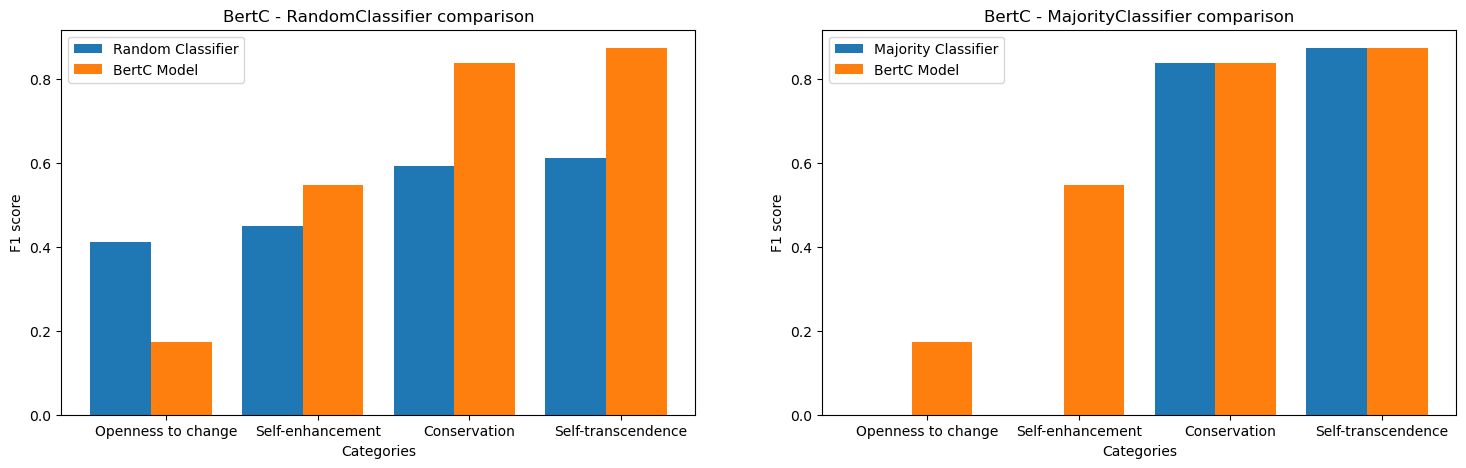

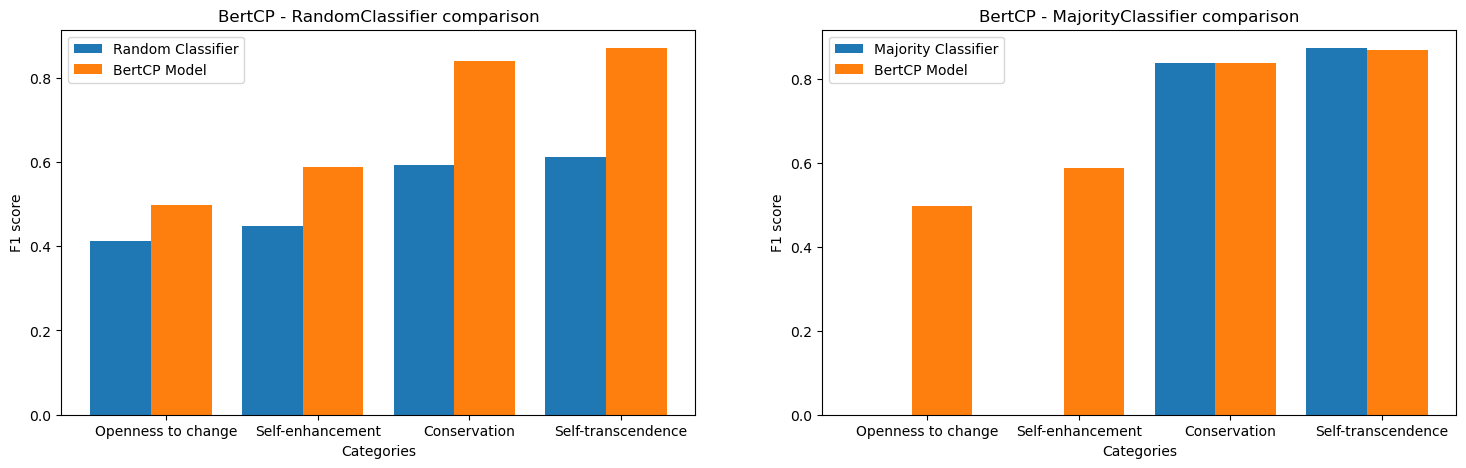

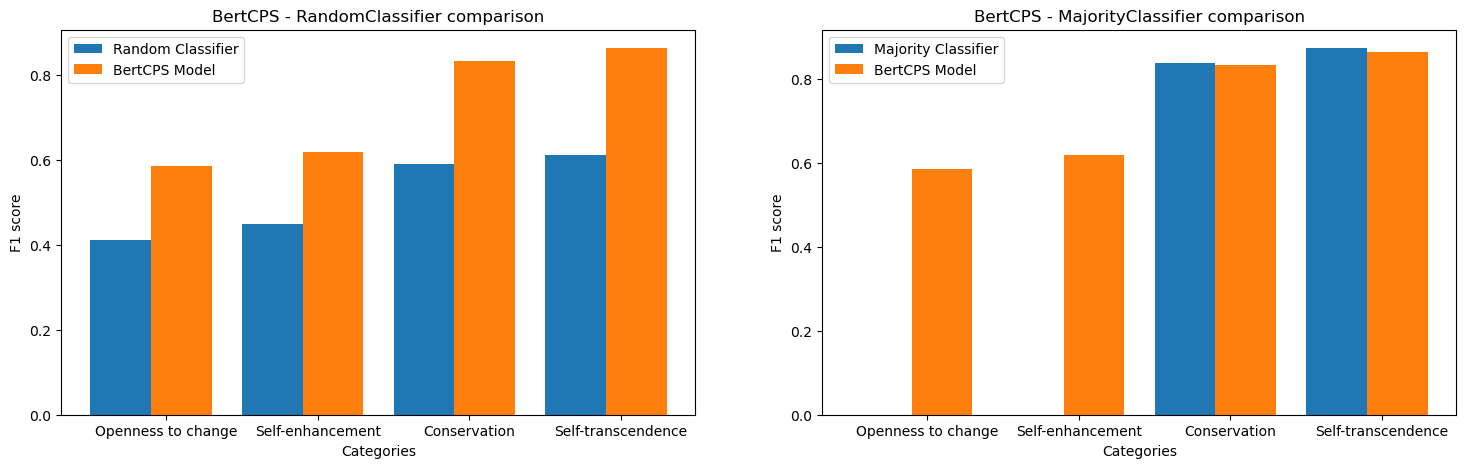

In [ ]:
compare_plot(best_bertC, majority_f1s, random_f1s, name='BertC')
compare_plot(best_bertCP, majority_f1s, random_f1s, name='BertCP')
compare_plot(best_bertCPS, majority_f1s, random_f1s, name='BertCPS')

#### 5.2 Discuss **difference in prediction** between the best performing BERT-based model and its variants.

In [ ]:
def print_best(best_model, name):
    total = 0
    print('-'*10)
    print(name)
    for i in range(len(categories)):
        print(f'F1 score for {categories[i]}: {round(best_model[i], 3)}')
        total += best_model[i]
    print(f'Macro F1 score: {round(total/len(best_model), 3)}')

In [ ]:
print_best(best_bertCPS, 'BEST MODEL')

----------
BEST MODEL
F1 score for Openness to change: 0.585
F1 score for Self-enhancement: 0.619
F1 score for Conservation: 0.835
F1 score for Self-transcendence: 0.864
Macro F1 score: 0.726


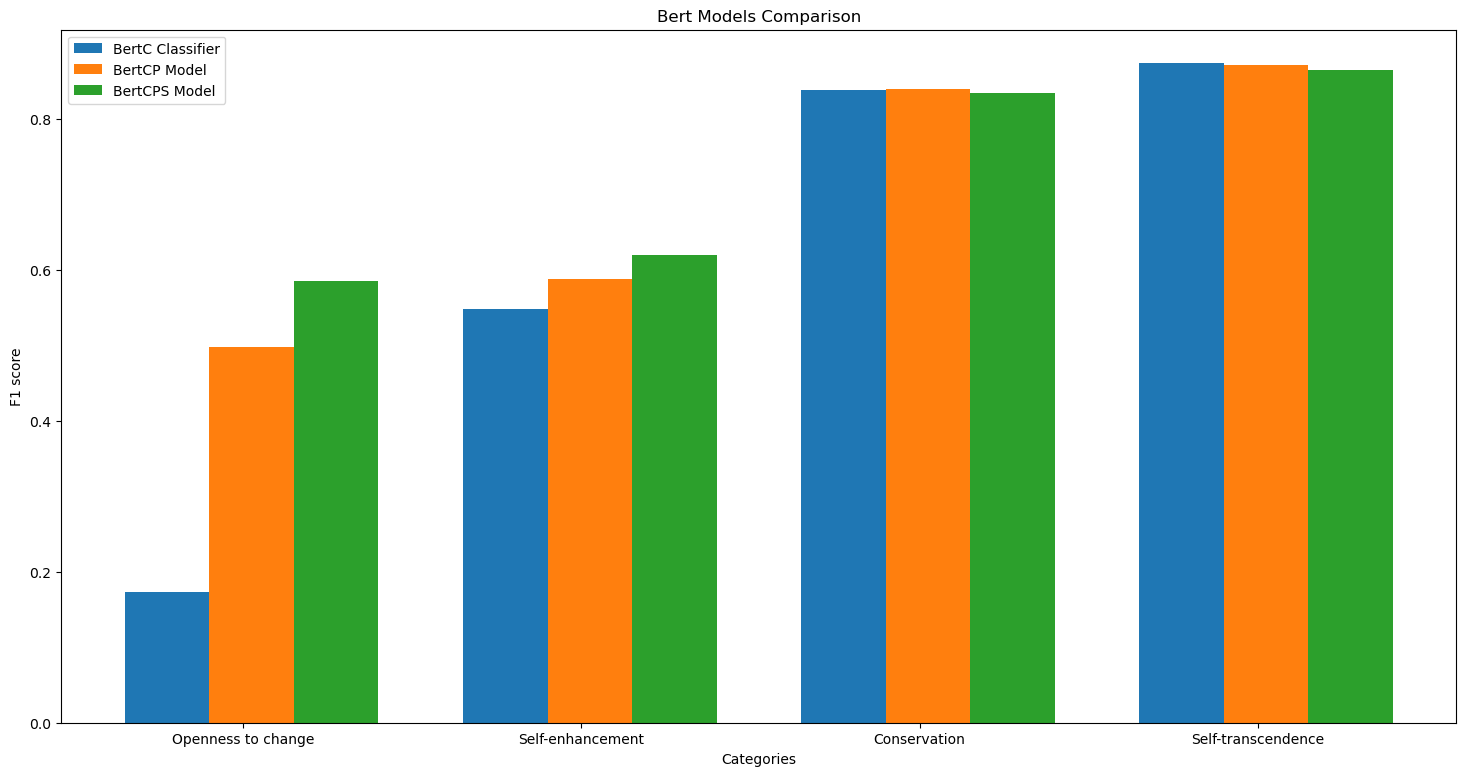

In [ ]:
# We consider only best seeds
Bert_compare(best_bertC, best_bertCP, best_bertCPS)

1. Not surprisingly, the CPS model emerges as the top-performing model, due to the richness of information encapsulated in its embeddings. Notably, the inclusion of Stance adds valuable insights into the relationship between Premise and Conclusion, fostering a more comprehensive understanding of the entire sentence from the model's perspective and resulting in a more balanced classification. It is observed that in models that receive simpler inputs there is a tendency towards "majority classifier" behavior, where a substantial number of examples are classified into the most frequent classes. Contrarily, models handling more complex inputs, such as CP and CPS, do partially overcome this problem. In case of C we can see that the models are so biased towards the majority classes that they outperform CPS, but when we look ad the less frequent one we can see a drop in performance as high as 0.4.

2. The most challenging classes appear to be those with lower representation in the dataset, namely "Openness to Change" and "Self-enhancement." Even better performing models demonstrate poorer performance for these categories, suggesting a challenge more inherent to the data distribution rather than from limitations of the architectures themselves. Addressing this issue may require the adoption of more complex models or the implementation of strategies such as class balancing.

3. In an initial attempt, we employed the "distill-BERT" architecture and observed similar results for CP and CPS. Subsequently, we utilized the "bert-base-uncased" architecture and noticed a differentiation in performance among the same set of models. This discrepancy could be attributed to the fact that distill-BERT is a simplified version of BERT, and its maximum performance may be more easily attained by CP.

4. In examining the performance of each model relative to the majority and random classifiers, the following observations can be made:

   - BertC demonstrates superiority over the classifiers in certain classes but falls short on achieving this for all classes. It can be surpassed by the majority classifier in the most frequent classes and by the random classifier in the less represented ones.

   - BertCP exhibits greater resilience, consistently outperforming the classifiers in nearly all cases, with only occasional exceptions when compared to the majority  classifier in the most frequent class.

   - A similar pattern of performance is observed for CPS, maintaining comparable effectiveness across various classes.